# Feature Engineering (FE) & Exploratory Data Analysis (EDA) for Healthcare Fraud Detection
Author: Shanrong Zhou

Roughly one-third of the $3.3T spent on healthcare in the US is attributable to fraud, waste, and abuse. The US Medicare system is particularly susceptible fraud and abuse, since it is harder to exclude problematic providers and is managed separately and with limited coordination across the states. In recent years, machine learning and data mining techniques are being used to address this problem. When constructing a healthcare fraud detection model, it is very important to extract the right features from the data.
- Objectives: This report uses a real dataset to conduct the Exploratory Data Analysis (EDA) and Feature Engineering (FE) process for healthcare fraud/abuse detection. The main objective is to create some useful features, that can capture the hospital reimbursement patterns and detect the anomalities. With the anomalities detected, we can further investigate the specific hospital and make alerts to potential fraud/abuse.
    * Detect any hospital that may abuse the resources compared to the average or median of its peers with the same DRG and Zipcode.
    * Detect any hospital that may abuse the resources compared to the average or median of its peers with the same DRG and City.
    * Detect any hospital that may abuse the resources compared to the average or median of its peers with the same DRG and State.
- Dataset: The Medicare Inpatient Hospitals by Geography and Service dataset provides information on hospital discharges for Original Medicare Part A beneficiaries by IPPS hospitals. This dataset contains information on the number of discharges, payments, and submitted charges organized by geography and Medicare Severity Diagnosis Related Group (DRG). 

# Table of Contents
- [Section 1 Data Preparation](#1)
    - [1.1 Understanding Data](#11)
    - [1.2 Create Data Fields](#12)
- [Section 2 Exploratory Data Analysis](#2)
    - [2.1 Distribution plots](#21)
    - [2.2 Count by state](#22)
    - [2.3 Count by top cities](#23)
    - [2.4 Count by top hospital referral regions](#24)
- [Section 3 Feature Engineering](#3)
  - [3.1 Benchmark: DRG & State average/median](#31)
      - [3.1.1 Feature 1: The ratio to the average of average medicare payment amount (grouping by DRG & State)](#311)
      - [3.1.2 Feature 2: The ratio to the average medicare reimbursement rate (grouping by DRG & State)](#312)
      - [3.1.3 Feature 3: The ratio to the median of average medicare payment amount (grouping by DRG & State)](#313)
      - [3.1.4 Feature 4: The ratio to the median medicare reimbursement rate (grouping by DRG & State)](#314)
  - [3.2 Benchmark: DRG & City average/median](#32)
      - [3.2.1 Feature 5: The ratio to the average of average medicare payment amount (grouping by DRG & City)](#321)
      - [3.2.2 Feature 6: The ratio to the average medicare reimbursement rate (grouping by DRG & City)](#322)
      - [3.2.3 Feature 7: The ratio to the median of average medicare payment amount (grouping by DRG & City)](#323)
      - [3.2.4 Feature 8: The ratio to the median medicare reimbursement rate (grouping by DRG & City)](#324)
  - [3.3 Benchmark: DRG & Hospital Referral Region average/median](#33)
      - [3.3.1 Feature 9: The ratio to the average of average medicare payment amount (grouping by DRG & Hospital Referral Region)](#331)
      - [3.3.2 Feature 10: The ratio to the average medicare reimbursement rate (grouping by DRG & Hospital Referral Region)](#332)
      - [3.3.3 Feature 11: The ratio to the median of average medicare payment amount (grouping by DRG & Hospital Referral Region)](#333)
      - [3.3.4 Feature 12: The ratio to the median medicare reimbursement rate (grouping by DRG & Hospital Referral Region)](#334)
- [Section 4 Conclusion](#4)
  - [4.1 Combine New Features to Dataset](#41)

## Section 1 Data Preparation <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
path = '/Users/alicezhou/Documents/Columbia/5420 Anomaly Detection/4. Exploratory Data Analysis (EDA)_Industry Case - Healthcare Fraud Detection/Assignment4'
data = pd.read_csv(path + '/inpatientCharges.csv')

###  1.1 Understanding Data <a class="anchor" id="11"></a>

Basic business understandings of the raw data:
- Each row is a hospital and it's DRG. The hospital is the healthcare service provider in the Medicare environment. Each of the hospital can serve multiple DRGs.
- Here are business interpretation of some data fields, which will help us for better understand the context and analyse the data insights later.
    - DRG Definition: Diagnosis Related Group is the classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.
    - Hospital Referral Region Description: It is a geographical categorization used to define specific areas in the United States that have similar patterns of healthcare resource use. These regions are defined by the Centers for Medicare and Medicaid Services (CMS) to analyze and compare healthcare utilization and costs across different locations.
    - Total Discharges: The number (count) of discharges billed by the provider for inpatient hospital services. It indicates the count of individuals who were admitted to and subsequently released from the provider's care.
    - Average Covered Charges: The average amount charged by the healthcare provider for services rendered to patients. It represents the cost of medical procedures and treatments that are typically covered by health insurance plans.
    - Average Total Payments (Total Payments / Total Discharges): The average payment received by the healthcare provider for services provided to patients. It includes payments made by insurance companies, patients, and other third-party payers.
    - Average Medicare Payment (Medicare Payment Amount / Total Discharges): The average payment made by the Medicare program to the healthcare provider for services rendered to Medicare beneficiaries. It specifically refers to the payments made by the government-funded Medicare insurance program.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   DRG Definition                        163065 non-null  object
 1   Provider Id                           163065 non-null  int64 
 2   Provider Name                         163065 non-null  object
 3   Provider Street Address               163065 non-null  object
 4   Provider City                         163065 non-null  object
 5   Provider State                        163065 non-null  object
 6   Provider Zip Code                     163065 non-null  int64 
 7   Hospital Referral Region Description  163065 non-null  object
 8    Total Discharges                     163065 non-null  int64 
 9    Average Covered Charges              163065 non-null  object
 10   Average Total Payments               163065 non-null  object
 11  Average Medic

In [4]:
# rename columns
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']

###  1.2 Create Data Fields <a class="anchor" id="12"></a>

- To capture hospital's actual usage of Medicare insurance, the average payment made by the Medicare program to the healthcare provider is the essential indicator. Therefore, feature engineering will focus on the "Average_Medicare_Payments". 
- However, since every hospital may have different size and provide specific service with various price, the payment amount may vary a lot. To address this problem, I want to look at the proportion of payment that Medicare program covers in the total payment. Therefore, I created another data field, "Medicare_Reimburse_Rate", which is the average medicare reimbursement rate (Average_Medicare_Payment/Average_Total_Payments). This is another focus of feature engineering.
- "Average_Covered_Charges" will be dropped since it could not provide insights to the actual reimbursement pattern. 
- I will also change data type and transfer spending amount with dollar sign into numeric.

In [5]:
# Drop Average_Covered_Charges since it's 
data = data.drop('Average_Covered_Charges',axis=1)

# Change data type and transfer spending amount with dollar sign into numeric
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_4161/751890370.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Average_Total_Payments'] = (data['Average_Total_Payments']
/var/folders/94/_mqchpnd0kv5pd779q9n49jh0000gn/T/ipykernel_4161/751890370.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']


In [6]:
# Creating Medicare_Reimburse_Rate for future feature engineering
data['Medicare_Reimburse_Rate'] = data['Average_Medicare_Payment']/data['Average_Total_Payments']*100
data['Medicare_Reimburse_Rate'] = data['Medicare_Reimburse_Rate'].round(2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   DRG                            163065 non-null  category
 1   Provider_Id                    163065 non-null  category
 2   Provider_Name                  163065 non-null  object  
 3   Provider_StreetAddress         163065 non-null  object  
 4   Provider_City                  163065 non-null  category
 5   Provider_State                 163065 non-null  category
 6   Provider_Zipcode               163065 non-null  int64   
 7   Hospital_referral_region_desp  163065 non-null  object  
 8   Total_Discharges               163065 non-null  int64   
 9   Average_Total_Payments         163065 non-null  float64 
 10  Average_Medicare_Payment       163065 non-null  float64 
 11  Medicare_Reimburse_Rate        163065 non-null  float64 
dtypes: category(4), 

## Section 2 Exploratory Data Analysis <a class="anchor" id="2"></a>

### 2.1 Distribution plots <a class="anchor" id="21"></a>

The national distribution plots of average total payments, average Medicare payments, and average Medicare payment rates will be shown. 

count    163065.000000
mean       9707.473804
std        7664.642598
min        2673.000000
25%        5234.500000
50%        7214.100000
75%       11286.400000
max      156158.180000
Name: Average_Total_Payments, dtype: float64


<AxesSubplot:xlabel='Average_Total_Payments', ylabel='Count'>

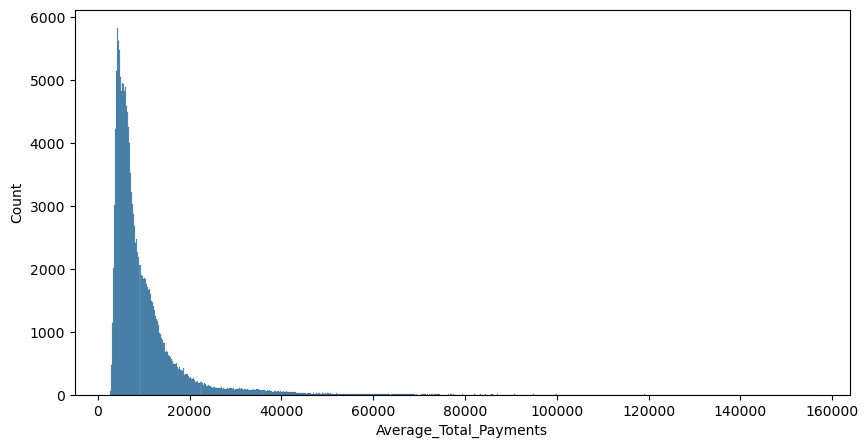

In [8]:
# Distribution plot of average total payments 
print(data['Average_Total_Payments'].describe())
plt.figure(figsize=(10,5)) 
sns.histplot(data['Average_Total_Payments'])

We can see 75% of the charges are under 11,286 dollars, but the highest charge amounts is 156,158 dollars and the lowerst charge amounts is 2,673 dollars. Both of them varies from the mean a lot. The standard deviation (7,664) is close to mean (9,707). This high variation could indicate resource mismanagement or abuse happened in the US healthcare system.
The distribution is right skewed, which could suggest that the hospitals with extremely large amounts might have biased charging practices.

count    163065.000000
mean       8494.490964
std        7309.467261
min        1148.900000
25%        4192.350000
50%        6158.460000
75%       10056.880000
max      154620.810000
Name: Average_Medicare_Payment, dtype: float64


<AxesSubplot:xlabel='Average_Medicare_Payment', ylabel='Count'>

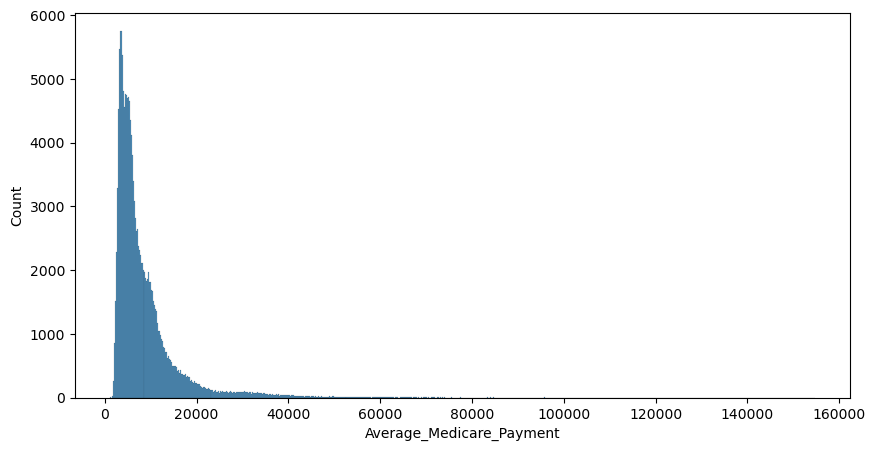

In [9]:
# Distribution plot of average Medicare payments 
print(data['Average_Medicare_Payment'].describe())
plt.figure(figsize=(10,5)) 
sns.histplot(data['Average_Medicare_Payment'])

We can see 75% of the Medicare payments are under 10,057 dollars, but the highest payment amounts is 154,621 dollars and the lowerst payment amounts is 1,149 dollars. Both of them varies from the mean a lot. The standard deviation (7,309) is close to mean (8,494). This high variation could indicate resource mismanagement or abuse happened in Medicare environment.
The distribution is right skewed, which could suggest that the hospitals with extremely large amounts might have biased charging or reimbursement practices.

count    163065.000000
mean         84.654478
std           8.791137
min           4.320000
25%          79.660000
50%          86.020000
75%          91.350000
max         100.000000
Name: Medicare_Reimburse_Rate, dtype: float64


<AxesSubplot:xlabel='Medicare_Reimburse_Rate', ylabel='Count'>

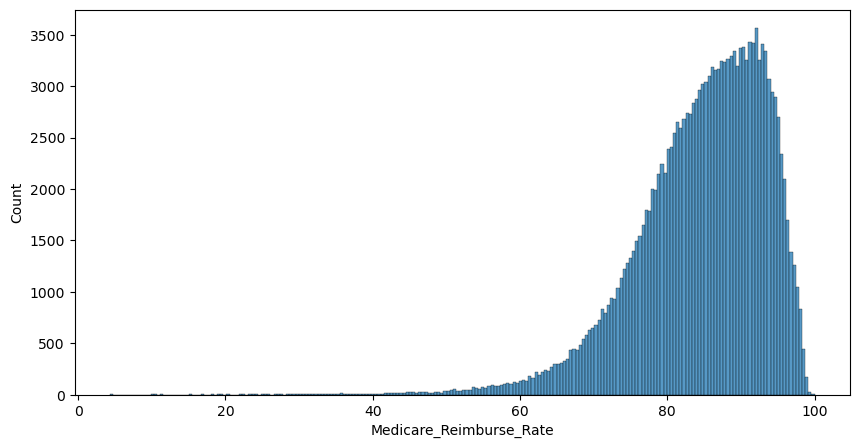

In [10]:
# Distribution plot of average Medicare reimbursement rate
print(data['Medicare_Reimburse_Rate'].describe())
plt.figure(figsize=(10,5)) 
sns.histplot(data['Medicare_Reimburse_Rate'])

We can see 75% of the average Medicare reimbursement rate are under 91%, but the highest is 100% and the lowerst is 4%. The distribution is left skewed and the variance is quite low. It shows that most of the claims can be reimbursed by Medicare program in a high reimbursement rate. Some of the hospitals with extremely low reimbursement rate might have obvious problematic claims, or it might suggest inadequate reimbursement or underutilization of resources. However, the high average reimbursement rate is also an alert that the potential loss of abuse and fraud in Medicare environment might have large amount.

### 2.2 Count by State <a class="anchor" id="22"></a>

Distribution of the number of hospitals across states can provide some insights to CMS (Federal Centers for Medicare and Medicaid Services), to better manage and allocate healthcare resources across states. 

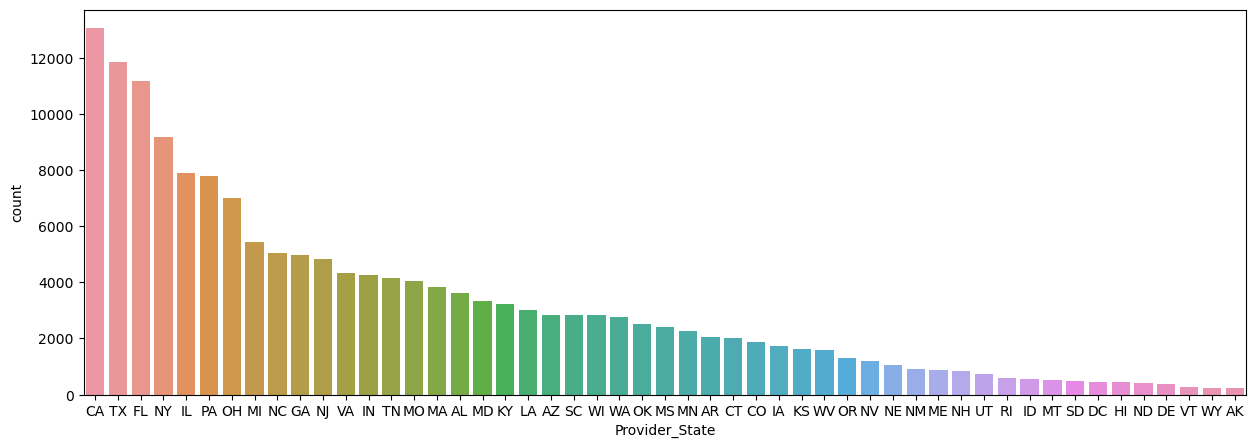

In [11]:
plt.figure(figsize=(15,5))
sns.countplot(x='Provider_State',data=data,order=data['Provider_State'].value_counts().index)
plt.rcParams["axes.labelsize"] = 20

From this histogram, California, Texas, and Florida has the highest number of hospital divisions participating in Medicare program across the states.

### 2.3 Count of top 20 cities <a class="anchor" id="23"></a>

Distribution of the number of hospitals across states can provide some insights to CMS (Federal Centers for Medicare and Medicaid Services), to better manage and allocate healthcare resources across cities.

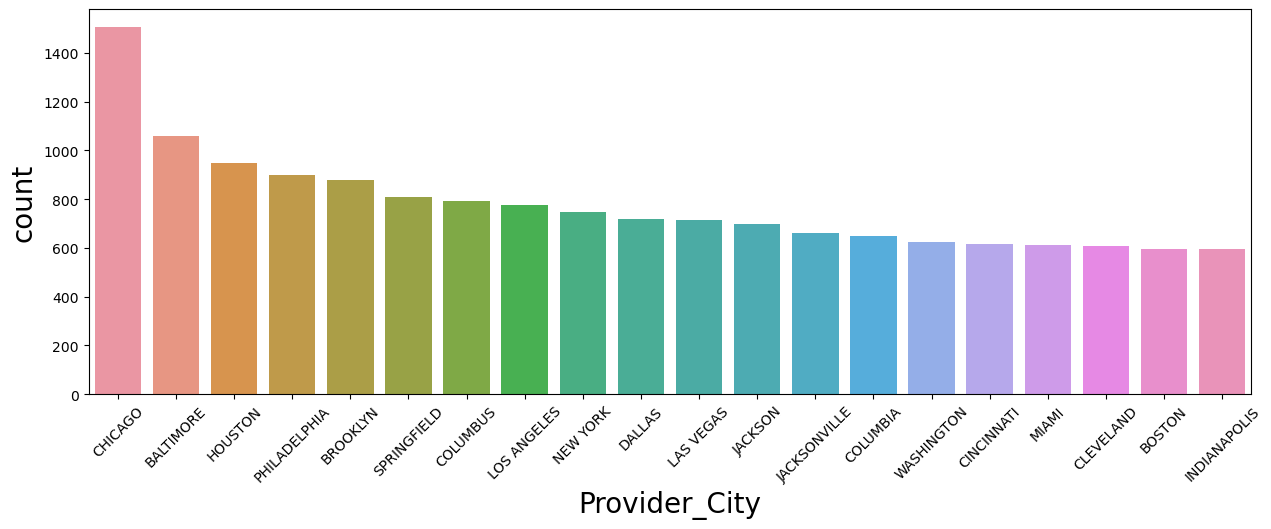

In [12]:
plt.figure(figsize=(15,5))
txt = data['Provider_City'].value_counts()[:20].index

chart = sns.countplot(
    x='Provider_City' ,data=data , order=txt
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.rcParams["axes.labelsize"] = 10

From this histogram, Chicago has the highest number of hospital divisions participating in Medicare program across the cities.

### 2.4 Count of top 20 hospital referral regions <a class="anchor" id="24"></a>

Distribution of the number of hospitals across states can provide some insights to CMS (Federal Centers for Medicare and Medicaid Services), to better manage and allocate healthcare resources across hospital referral regions.

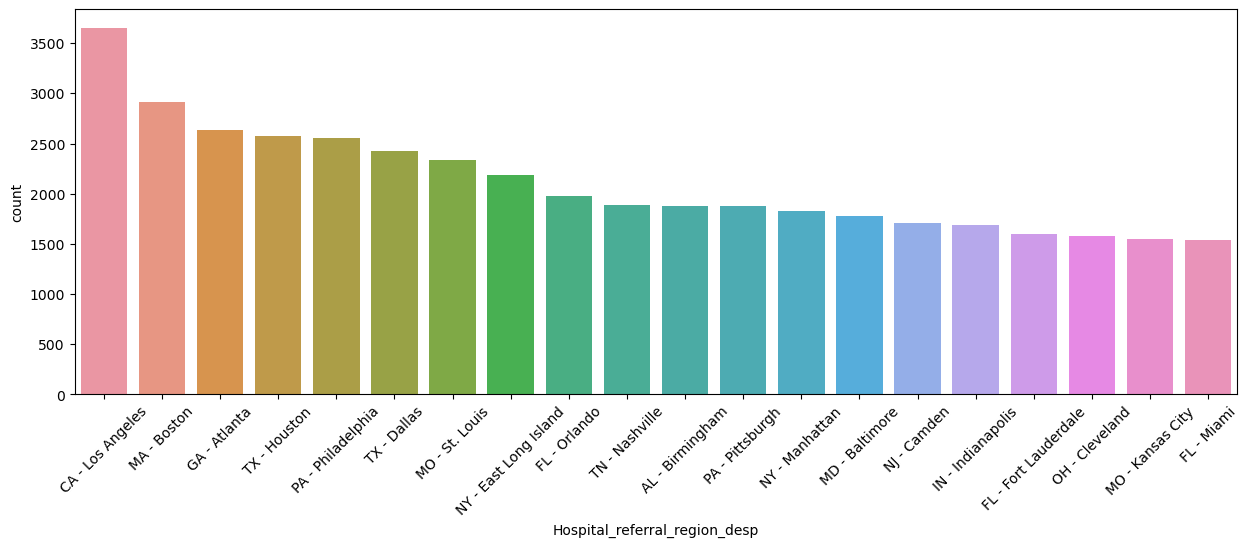

In [13]:
plt.figure(figsize=(15,5))
txt = data['Hospital_referral_region_desp'].value_counts()[:20].index

chart = sns.countplot(
    x='Hospital_referral_region_desp' ,data=data , order=txt
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.rcParams["axes.labelsize"] = 10

From this histogram, Los Angeles has the highest number of hospital divisions participating in Medicare program across the hospital referral regions.

## Section 3 Feature Engineering <a class="anchor" id="3"></a>
Based on the business understandings and exploratory data analysis stated above, I decided to start the feature engineering process with benchmarking. There are 3 steps for creating each new feature:
1. Group hospitals the by diagnosis (DRG) and geographical (state, city, or hospital referral region) categorization.
2. Calculate the average or median of the defined hospital group's Medicare payment amount or reimbursement rate as the benchmark for single hospital comparison. 
3. Create new feature to reflect the comparison directly (eg. ratio of each hospital to the average or median of the defined hospital group). 

This method tells the hospital reimbursement pattern of a defined hospital group. By selecting the hospitals that deviated a lot from the benchmark, we can define them as anomalies for further investigation, in order to detect potential healthcare resource abuse/fraud. 

###  3.1 Benchmark: DRG & State average/median <a class="anchor" id="31"></a>
Hospitals are grouped by DRG & State.

####  3.1.1 Feature 1: The ratio to the average of average medicare payment amount (grouping by DRG & State) <a class="anchor" id="311"></a>

- The defined hospital group's average of average medicare payment amount is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

In [14]:
# create bencharmark table
benchmark1 = data.groupby(['Provider_State','DRG'])['Average_Total_Payments'].mean().reset_index()
benchmark1.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
benchmark1.head()

,Provider_State,DRG,Avg_Payment_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8401.950000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8799.000000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21608.010000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,12555.548333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,9275.867500


In [15]:
# add the new feature average payment to the dataset 
data1 = pd.merge(data, benchmark1, how='left', on=['Provider_State', 'DRG'])
# Feature 1: ratio of hospital's average medicare payment and the group's average of average medicare payment
data1['drg_state_avg_ratio_amount'] = np.where(data1['Avg_Payment_ByStateDRG']==0,0,data1['Average_Medicare_Payment'] / data1['Avg_Payment_ByStateDRG'])
data1['drg_state_avg_ratio_amount'].describe()

count    163065.000000
mean          0.846842
std           0.193528
min           0.266055
25%           0.725021
50%           0.808729
75%           0.917944
max           4.446219
Name: drg_state_avg_ratio_amount, dtype: float64

In [16]:
# cut by percentile for plotting
var = 'drg_state_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data1[binned_var] = pd.qcut(data1[var],percentile, duplicates = 'drop')
data1[['drg_state_avg_ratio_amount_D']]

,drg_state_avg_ratio_amount_D
0,"(0.809, 0.955]"
1,"(0.809, 0.955]"
2,"(0.706, 0.809]"
3,"(0.706, 0.809]"
4,"(0.809, 0.955]"
...,...
163060,"(0.618, 0.706]"
163061,"(0.544, 0.618]"
163062,"(0.809, 0.955]"
163063,"(1.228, 1.505]"


[Text(0, 0, '(0.265, 0.544]'),
 Text(1, 0, '(0.544, 0.618]'),
 Text(2, 0, '(0.618, 0.706]'),
 Text(3, 0, '(0.706, 0.809]'),
 Text(4, 0, '(0.809, 0.955]'),
 Text(5, 0, '(0.955, 1.228]'),
 Text(6, 0, '(1.228, 1.505]'),
 Text(7, 0, '(1.505, 4.446]')]

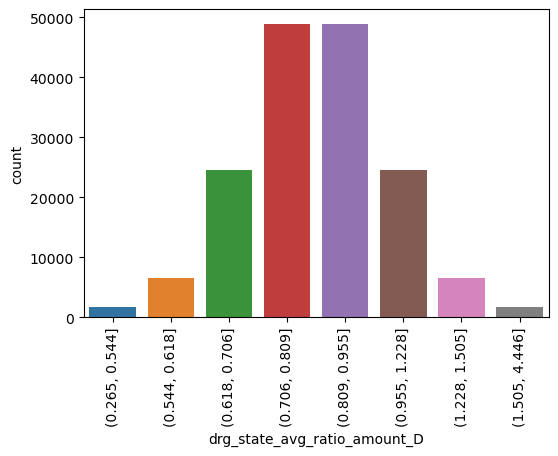

In [17]:
# Histogram for comparing ratio of hospital's average medicare payment and the group's average of average medicare payment
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_state_avg_ratio_amount_D", data=data1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' average Medicare payment amounts are around the group's average, compared to the similar hospitals serving same DRG in the same state.
- From the above distribution histogram, we can see that some hospitals' average Medicare payment amounts can be more than 4 times of the group's average, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within a similar range of prices. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing, duplicate billing and kickbacks. 
- Some hospitals' average Medicare payment amounts can be less than 30% of the group's average. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [18]:
data1[data1['drg_state_avg_ratio_amount']>4]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Payment_ByStateDRG,drg_state_avg_ratio_amount,drg_state_avg_ratio_amount_D
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.00,89.82,8374.755758,4.446219,"(1.505, 4.446]"
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,CROWN POINT,IN,46307,IN - Gary,14,131187.35,130466.57,99.45,29810.952564,4.376464,"(1.505, 4.446]"
111075,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,390256,MILTON S HERSHEY MEDICAL CENTER,500 UNIVERSITY DRIVE,HERSHEY,PA,17033,PA - Harrisburg,15,100018.33,99114.86,99.10,23405.411081,4.234699,"(1.505, 4.446]"


There are 3 hospitals whose average Medicare payment amounts are more than 4 times of the group's average. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 89%). The reimbursement rates of PINNACLE HOSPITAL and MILTON S HERSHEY MEDICAL CENTER are even higher than 99%. The average payments of their peers, serving same ORG in the same state, are within a normal range. These 3 hospitals' high average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse. 

In [19]:
data1[data1['drg_state_avg_ratio_amount']<0.3]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Payment_ByStateDRG,drg_state_avg_ratio_amount,drg_state_avg_ratio_amount_D
47957,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,SIOUX FALLS,SD,57108,SD - Sioux Falls,121,83484.14,9316.11,11.16,31166.452500,0.298915,"(0.265, 0.544]"
109837,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,330286,GOOD SAMARITAN HOSPITAL MEDICAL CENTER,1000 MONTAUK HIGHWAY,WEST ISLIP,NY,11795,NY - East Long Island,12,44431.83,8993.91,20.24,31039.448431,0.289757,"(0.265, 0.544]"
111962,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,120011,KAISER FOUNDATION HOSPITAL,3288 MOANALUA RD,HONOLULU,HI,96819,HI - Honolulu,28,20955.35,5215.00,24.89,19601.224545,0.266055,"(0.265, 0.544]"


There are 3 hospitals whose average Medicare payment amounts are less than 30% of the group's average. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 25%). The reimbursement rates of AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC is even less than 12%. The average payments of their peers, serving same ORG in the same state, are within a normal range. These 3 hospitals' low average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement. 

####  3.1.2 Feature 2: The ratio to the average medicare reimbursement rate (grouping by DRG & State) <a class="anchor" id="312"></a>

- The defined hospital group's average of medicare reimbursement rate is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.056799999999999996, 0.726]'),
 Text(1, 0, '(0.726, 0.861]'),
 Text(2, 0, '(0.861, 0.96]'),
 Text(3, 0, '(0.96, 1.013]'),
 Text(4, 0, '(1.013, 1.05]'),
 Text(5, 0, '(1.05, 1.095]'),
 Text(6, 0, '(1.095, 1.145]'),
 Text(7, 0, '(1.145, 1.382]')]

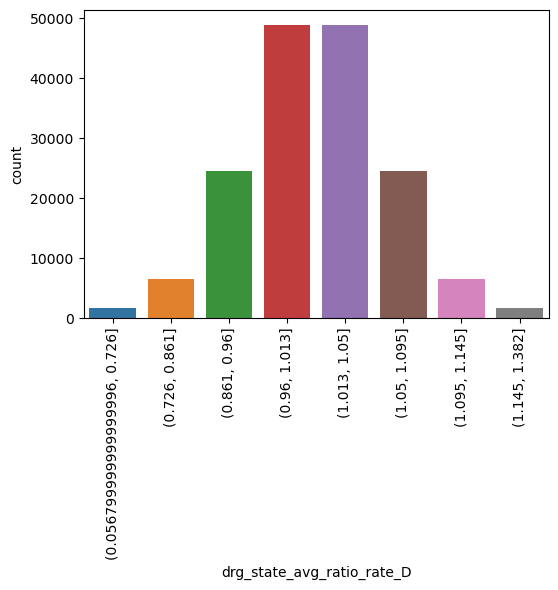

In [20]:
# create bencharmark table
benchmark2 = data.groupby(['Provider_State','DRG'])['Medicare_Reimburse_Rate'].mean().reset_index()
benchmark2.columns = ['Provider_State','DRG','Avg_Rate_ByStateDRG']
# add the new feature to the dataset 
data2 = pd.merge(data, benchmark2, how='left', on=['Provider_State', 'DRG'])
data2['drg_state_avg_ratio_rate'] = np.where(data2['Avg_Rate_ByStateDRG']==0,0,data2['Medicare_Reimburse_Rate'] / data2['Avg_Rate_ByStateDRG'])
# cut by percentile for plotting
var = 'drg_state_avg_ratio_rate'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data2[binned_var] = pd.qcut(data2[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_state_avg_ratio_rate_D", data=data2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' average Medicare reimbursement rates are around the group's average, compared to the similar hospitals serving same DRG in the same state. 
- From the above distribution histogram, we can see that some hospitals' average Medicare reimbursement rates are just more than 1.3 times of the group's average, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. We've discussed in EDA that the national average Medicare reimbursement rate is very high (85%), so the just 30% increase could make the reimbursement rate reaching to 100%, which means all of the hospital's bills are reimbursed by Medicare. Same diagnosis should be treated with similar treatments, which are within the same range of reimbursement rate, according to Medicare's insurance policy. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing. 
- Some hospitals' average Medicare reimbursement rates can be less than 20% of the group's average. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [21]:
data2[data2['drg_state_avg_ratio_rate']>1.35]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Rate_ByStateDRG,drg_state_avg_ratio_rate,drg_state_avg_ratio_rate_D
49791,251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY...,430027,SANFORD USD MEDICAL CENTER,1305 W 18TH ST PO BOX 5039,SIOUX FALLS,SD,57117,SD - Sioux Falls,44,11301.00,10315.09,91.28,66.203333,1.378783,"(1.145, 1.382]"
83428,313 - CHEST PAIN,280111,COLUMBUS COMMUNITY HOSPITAL,4600 38TH ST,COLUMBUS,NE,68601,NE - Omaha,35,4606.42,3864.37,83.89,61.964667,1.353836,"(1.145, 1.382]"
108577,439 - DISORDERS OF PANCREAS EXCEPT MALIGNANCY ...,280013,THE NEBRASKA MEDICAL CENTER,987400 NEBRASKA MEDICAL CENTER,OMAHA,NE,68198,NE - Omaha,21,8054.57,6659.09,82.67,59.826667,1.381825,"(1.145, 1.382]"
158119,885 - PSYCHOSES,510001,WEST VIRGINIA UNIVERSITY HOSPITALS,MEDICAL CENTER DRIVE,MORGANTOWN,WV,26506,WV - Morgantown,14,7331.28,6929.28,94.52,68.522500,1.379401,"(1.145, 1.382]"


There are 4 hospitals whose average Medicare reimbursement rates are more than 1.35 times of the group's average. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 82%) compared to to their peers (less than 69%). The average reimbursement rates of their peers, serving same ORG in the same state, are within a normal range. These 5 hospitals' high average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [22]:
data2[data2['drg_state_avg_ratio_rate']<0.2]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Rate_ByStateDRG,drg_state_avg_ratio_rate,drg_state_avg_ratio_rate_D
20388,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,READING,PA,19605,PA - Reading,143,72797.93,7718.09,10.60,87.216737,0.121536,"(0.056799999999999996, 0.726]"
38923,203 - BRONCHITIS & ASTHMA W/O CC/MCC,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,RI - Providence,11,41482.09,1790.18,4.32,74.732857,0.057806,"(0.056799999999999996, 0.726]"
47957,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,SIOUX FALLS,SD,57108,SD - Sioux Falls,121,83484.14,9316.11,11.16,67.942500,0.164257,"(0.056799999999999996, 0.726]"
49145,249 - PERC CARDIOVASC PROC W NON-DRUG-ELUTING ...,500051,OVERLAKE HOSPITAL MEDICAL CENTER,1035-116TH AVE NE,BELLEVUE,WA,98004,WA - Seattle,23,84499.26,8500.60,10.06,79.154000,0.127094,"(0.056799999999999996, 0.726]"


There are 4 hospitals whose average Medicare payment amounts are less than 20% of the group's average. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 12%). The reimbursement rates of STURDY MEMORIAL HOSPITAL is even less than 5%. The average payments of their peers, serving same ORG in the same state, are within a normal range. These 5 hospitals' low average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

####  3.1.3 Feature 3: The ratio to the median of average medicare payment amount (grouping by DRG & State) <a class="anchor" id="313"></a>

- The defined hospital group's median of average medicare payment amount is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group median is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.367, 0.714]'),
 Text(1, 0, '(0.714, 0.805]'),
 Text(2, 0, '(0.805, 0.897]'),
 Text(3, 0, '(0.897, 1.0]'),
 Text(4, 0, '(1.0, 1.167]'),
 Text(5, 0, '(1.167, 1.527]'),
 Text(6, 0, '(1.527, 1.898]'),
 Text(7, 0, '(1.898, 6.031]')]

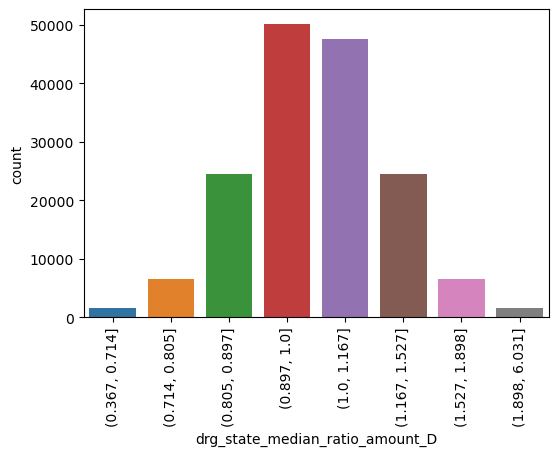

In [23]:
# create bencharmark table
benchmark3 = data.groupby(['Provider_State','DRG'])['Average_Medicare_Payment'].median().reset_index()
benchmark3.columns = ['Provider_State','DRG','Median_Amount_ByStateDRG']
# add the new feature to the dataset 
data3 = pd.merge(data, benchmark3, how='left', on=['Provider_State', 'DRG'])
data3['drg_state_median_ratio_amount'] = np.where(data3['Median_Amount_ByStateDRG']==0,0,data3['Average_Medicare_Payment'] / data3['Median_Amount_ByStateDRG'])
# cut by percentile for plotting
var = 'drg_state_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data3[binned_var] = pd.qcut(data3[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_state_median_ratio_amount_D", data=data3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' median Medicare payment amounts are around the group's median, compared to the similar hospitals serving same DRG in the same state.
- From the above distribution histogram, we can see that some hospitals' median Medicare payment amounts can be more than 5 times of the group's median, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within a similar range of prices. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing and kickbacks. 
- Some hospitals' median medicare payment amounts can be less than 40% of the group's median. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [24]:
data3[data3['drg_state_median_ratio_amount']>5]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Amount_ByStateDRG,drg_state_median_ratio_amount,drg_state_median_ratio_amount_D
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.00,89.82,6174.120,6.030981,"(1.898, 6.031]"
86797,315 - OTHER CIRCULATORY SYSTEM DIAGNOSES W CC,490009,UNIVERSITY OF VIRGINIA MEDICAL CENTER,JEFFERSON PARK AVE,CHARLOTTESVILLE,VA,22908,VA - Charlottesville,18,26704.11,26015.88,97.42,5159.895,5.041940,"(1.898, 6.031]"
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,CROWN POINT,IN,46307,IN - Gary,14,131187.35,130466.57,99.45,21780.130,5.990165,"(1.898, 6.031]"
111075,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,390256,MILTON S HERSHEY MEDICAL CENTER,500 UNIVERSITY DRIVE,HERSHEY,PA,17033,PA - Harrisburg,15,100018.33,99114.86,99.10,18921.540,5.238203,"(1.898, 6.031]"


There are 4 hospitals whose median Medicare payment amounts are more than 5 times of the group's median. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 89%). The reimbursement rates of PINNACLE HOSPITAL, MILTON S HERSHEY MEDICAL CENTER, and UNIVERSITY OF VIRGINIA MEDICAL CENTERare even higher than 97%. The median payments of their peers, serving same ORG in the same state, are within a normal range. To be noted, there are 3 hospitals (THE JOHNS HOPKINS HOSPITAL, PINNACLE HOSPITAL and MILTON S HERSHEY MEDICAL CENTER) that have been identified as anomalies in feature 1's (ratio to the average of  average medicare payment amount (grouping by DRG & State)) distribution as well. These 4 hospitals' high median Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [25]:
data3[data3['drg_state_median_ratio_amount']<0.4]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Amount_ByStateDRG,drg_state_median_ratio_amount,drg_state_median_ratio_amount_D
109837,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,330286,GOOD SAMARITAN HOSPITAL MEDICAL CENTER,1000 MONTAUK HIGHWAY,WEST ISLIP,NY,11795,NY - East Long Island,12,44431.83,8993.91,20.24,24450.88,0.367836,"(0.367, 0.714]"
111962,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,120011,KAISER FOUNDATION HOSPITAL,3288 MOANALUA RD,HONOLULU,HI,96819,HI - Honolulu,28,20955.35,5215.00,24.89,14085.45,0.370240,"(0.367, 0.714]"


There are 2 hospitals whose median Medicare payment amounts are less than 40% of the group's median. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 25%). To be noted, there are 3 hospitals (GOOD SAMARITAN HOSPITAL MEDICAL CENTER, KAISER FOUNDATION HOSPITAL) that have been identified as anomalies in feature 1's (ratio to the average of average medicare payment amount (grouping by DRG & State)) distribution as well. The median payments of their peers, serving same ORG in the same state, are within a normal range. These 2 hospitals' low median Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

####  3.1.4 Feature 4: The ratio to the median medicare reimbursement rate (grouping by DRG & State)
 <a class="anchor" id="314"></a>

- The defined hospital group's median of medicare reimbursement rate is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group median is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.0554, 0.709]'),
 Text(1, 0, '(0.709, 0.845]'),
 Text(2, 0, '(0.845, 0.948]'),
 Text(3, 0, '(0.948, 1.0]'),
 Text(4, 0, '(1.0, 1.032]'),
 Text(5, 0, '(1.032, 1.078]'),
 Text(6, 0, '(1.078, 1.127]'),
 Text(7, 0, '(1.127, 1.431]')]

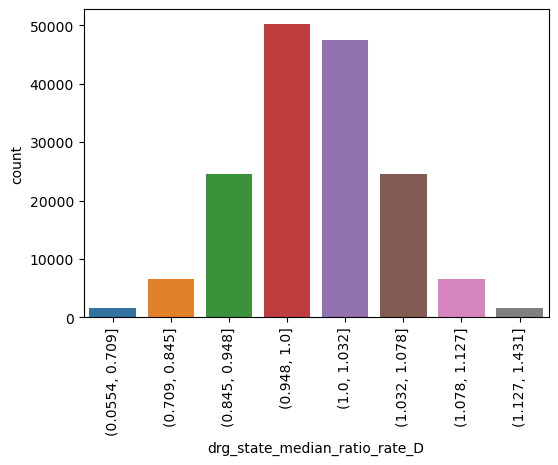

In [26]:
# create bencharmark table
benchmark4 = data.groupby(['Provider_State','DRG'])['Medicare_Reimburse_Rate'].median().reset_index()
benchmark4.columns = ['Provider_State','DRG','Median_Rate_ByStateDRG']
# add the new feature to the dataset 
data4 = pd.merge(data, benchmark4, how='left', on=['Provider_State', 'DRG'])
data4['drg_state_median_ratio_rate'] = np.where(data4['Median_Rate_ByStateDRG']==0,0,data4['Medicare_Reimburse_Rate'] / data4['Median_Rate_ByStateDRG'])
# cut by percentile for plotting
var = 'drg_state_median_ratio_rate'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data4[binned_var] = pd.qcut(data4[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_state_median_ratio_rate_D", data=data4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' median Medicare reimbursement rates are around the group's median, compared to the similar hospitals serving same DRG in the same state. 
- From the above distribution histogram, we can see that some hospitals' median Medicare reimbursement rates are just more than 1.3 times of the group's median, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. We've discussed in EDA that the national median Medicare reimbursement rate is very high (85%), so the just 30% increase could make the reimbursement rate reaching to 100%, which means all of the hospital's bills are reimbursed by Medicare. Same diagnosis should be treated with similar treatments, which are within the same range of reimbursement rate, according to Medicare's insurance policy. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing. 
- Some hospitals' median Medicare reimbursement rates can be less than 20% of the group's median. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [27]:
data4[data4['drg_state_median_ratio_rate']>1.4]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Rate_ByStateDRG,drg_state_median_ratio_rate,drg_state_median_ratio_rate_D
77583,310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDER...,20026,ALASKA NATIVE MEDICAL CENTER,4315 DIPLOMACY DR,ANCHORAGE,AK,99508,AK - Anchorage,24,7178.66,6333.66,88.23,62.12,1.420316,"(1.127, 1.431]"
161332,948 - SIGNS & SYMPTOMS W/O MCC,120006,CASTLE MEDICAL CENTER,640 ULUKAHIKI ST,KAILUA,HI,96734,HI - Honolulu,20,5594.45,4462.45,79.77,55.74,1.431109,"(1.127, 1.431]"


There are 2 hospitals whose median Medicare reimbursement rates are more than 1.4 times of the group's median. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 82%) compared to to their peers (less than 70%). The median reimbursement rates of their peers, serving same ORG in the same state, are within a normal range. These 5 hospitals' high median Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [28]:
data4[data4['drg_state_median_ratio_rate']<0.2]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Rate_ByStateDRG,drg_state_median_ratio_rate,drg_state_median_ratio_rate_D
20388,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,READING,PA,19605,PA - Reading,143,72797.93,7718.09,10.60,89.490,0.118449,"(0.0554, 0.709]"
38923,203 - BRONCHITIS & ASTHMA W/O CC/MCC,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,RI - Providence,11,41482.09,1790.18,4.32,76.660,0.056353,"(0.0554, 0.709]"
47957,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,SIOUX FALLS,SD,57108,SD - Sioux Falls,121,83484.14,9316.11,11.16,85.315,0.130809,"(0.0554, 0.709]"
49145,249 - PERC CARDIOVASC PROC W NON-DRUG-ELUTING ...,500051,OVERLAKE HOSPITAL MEDICAL CENTER,1035-116TH AVE NE,BELLEVUE,WA,98004,WA - Seattle,23,84499.26,8500.60,10.06,84.860,0.118548,"(0.0554, 0.709]"


There are 4 hospitals whose median Medicare payment amounts are less than 20% of the group's median. All of them are located in different states, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 12%). The reimbursement rates of STURDY MEMORIAL HOSPITAL is even less than 5%. The median payments of their peers, serving same ORG in the same state, are within a normal range. These 5 hospitals' low median Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. To be noted, these 4 hospitals are all identified as anomalies in feature 2's (ratio to the average of medicare reimbursement rates (grouping by DRG & State)) distribution as well. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

###  3.2 Benchmark: DRG & City average/median <a class="anchor" id="32"></a>
Hospitals are grouped by DRG & City.

####  3.2.1 Feature 5: The ratio to the average of average medicare payment amount (grouping by DRG & City) <a class="anchor" id="321"></a>

- The defined hospital group's average of average medicare payment amount is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.261, 0.7]'),
 Text(1, 0, '(0.7, 0.809]'),
 Text(2, 0, '(0.809, 0.95]'),
 Text(3, 0, '(0.95, 1.0]'),
 Text(4, 0, '(1.0, 1.023]'),
 Text(5, 0, '(1.023, 1.21]'),
 Text(6, 0, '(1.21, 1.435]'),
 Text(7, 0, '(1.435, 3.847]')]

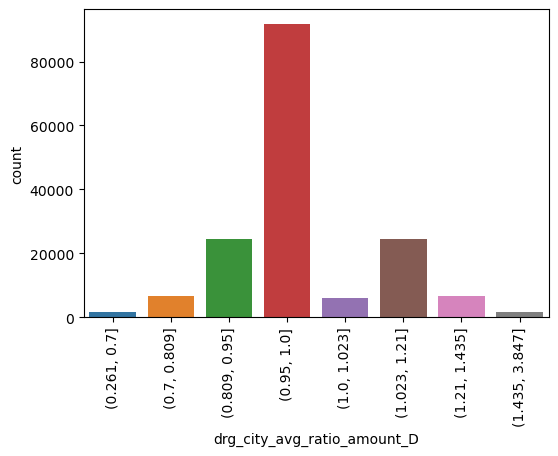

In [29]:
# create bencharmark table
benchmark5 = data.groupby(['Provider_City','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark5.columns = ['Provider_City','DRG','Avg_Amount_ByCityDRG']
# add the new feature to the dataset 
data5 = pd.merge(data, benchmark5, how='left', on=['Provider_City', 'DRG'])
data5['drg_city_avg_ratio_amount'] = np.where(data5['Avg_Amount_ByCityDRG']==0,0,data5['Average_Medicare_Payment'] / data5['Avg_Amount_ByCityDRG'])
# cut by percentile for plotting
var = 'drg_city_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data5[binned_var] = pd.qcut(data5[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_city_avg_ratio_amount_D", data=data5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' average Medicare payment amounts are around the group's average, compared to the similar hospitals serving same DRG in the same city.
- From the above distribution histogram, we can see that some hospitals' average Medicare payment amounts can be more than 3 times of the group's average, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within a similar range of prices. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing and kickbacks. 
- Some hospitals' average Medicare payment amounts can be less than 30% of the group's average. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [30]:
data5[data5['drg_city_avg_ratio_amount'] > 3]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Amount_ByCityDRG,drg_city_avg_ratio_amount,drg_city_avg_ratio_amount_D
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.0,89.82,9679.581,3.846861,"(1.435, 3.847]"


There is 1 hospital whose average Medicare payment amounts are more than 3 times of the group's average. To be noted, this hospital has been identified as anomaly in feature 1 and 3's (the Medicare payment amount ratios under the DRG & City group) distributions as well. The average payment of its peers, serving same ORG in the same city, is within a normal range. This hospital's high average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [31]:
data5[data5['drg_city_avg_ratio_amount'] < 0.3]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Amount_ByCityDRG,drg_city_avg_ratio_amount,drg_city_avg_ratio_amount_D
109456,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150126,FRANCISCAN ST ANTHONY HEALTH - CROWN POINT,1201 S MAIN ST,CROWN POINT,IN,46307,IN - Gary,13,23478.61,19644.84,83.67,75055.705,0.261737,"(0.261, 0.7]"


There is 1 hospital whose average Medicare payment amounts are less than 30% of the group's average. However, its reimbursement rate (84%) is closed to the national average reimbursement rate. Therefore, the low average Medicare payment amounts might be caused by the hospital's small size or the DRG (460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC) might not be the hospital's specialized service. It may not be an anomaly.

####  3.2.2 Feature 6: The ratio to the average medicare reimbursement rate (grouping by DRG & City) <a class="anchor" id="322"></a>

- The defined hospital group's average of medicare reimbursement rate is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.213, 0.831]'),
 Text(1, 0, '(0.831, 0.929]'),
 Text(2, 0, '(0.929, 0.992]'),
 Text(3, 0, '(0.992, 1.0]'),
 Text(4, 0, '(1.0, 1.014]'),
 Text(5, 0, '(1.014, 1.069]'),
 Text(6, 0, '(1.069, 1.134]'),
 Text(7, 0, '(1.134, 1.786]')]

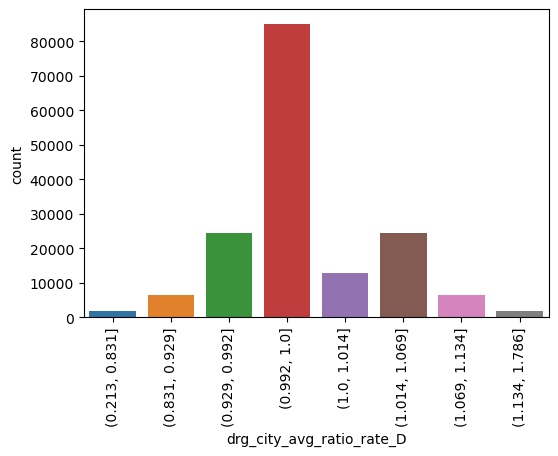

In [32]:
# create bencharmark table
benchmark6 = data.groupby(['Provider_City','DRG'])['Medicare_Reimburse_Rate'].mean().reset_index()
benchmark6.columns = ['Provider_City','DRG','Avg_Rate_ByCityDRG']
# add the new feature to the dataset 
data6 = pd.merge(data, benchmark6, how='left', on=['Provider_City', 'DRG'])
data6['drg_city_avg_ratio_rate'] = np.where(data6['Avg_Rate_ByCityDRG']==0,0,data6['Medicare_Reimburse_Rate'] / data6['Avg_Rate_ByCityDRG'])
# cut by percentile for plotting
var = 'drg_city_avg_ratio_rate'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data6[binned_var] = pd.qcut(data6[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_city_avg_ratio_rate_D", data=data6)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' average Medicare reimbursement rates are around the group's average, compared to the similar hospitals serving same DRG in the same city. 
- From the above distribution histogram, we can see that some hospitals' average Medicare reimbursement rates are just more than 1.7 times of the group's average, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. We've discussed in EDA that the national average Medicare reimbursement rate is very high (85%), so the just 70% increase could make the reimbursement rate reaching to 100%, which means all of the hospital's bills are reimbursed by Medicare. Same diagnosis should be treated with similar treatments, which are within the same range of reimbursement rate, according to Medicare's insurance policy. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing. 
- Some hospitals' average Medicare reimbursement rates can be less than 30% of the group's average. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [33]:
data6[data6['drg_city_avg_ratio_rate'] > 1.7]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Rate_ByCityDRG,drg_city_avg_ratio_rate,drg_city_avg_ratio_rate_D
20368,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390044,READING HOSPITAL MEDICAL CENTER,SIXTH AVENUE AND SPRUCE ST,READING,PA,19603,PA - Reading,117,9842.23,8687.55,88.27,49.435,1.785577,"(1.134, 1.786]"
47955,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430027,SANFORD USD MEDICAL CENTER,1305 W 18TH ST PO BOX 5039,SIOUX FALLS,SD,57117,SD - Sioux Falls,183,12408.42,11159.24,89.93,50.545,1.779207,"(1.134, 1.786]"


There are 2 hospitals whose average Medicare reimbursement rates are more than 1.35 times of the group's average. All of them are located in different cities, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 88%) compared to to their peers (less than 51%). The average reimbursement rates of their peers, serving same ORG in the same cities, are within a normal range. To be noted, the hospital (SANFORD USD MEDICAL CENTER) has been identified as anomaly in feature 2's (ratio to the average of average medicare reimbursement rate (grouping by DRG & State)) distribution as well. This hospital's high average Medicare reimbursement rates can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [34]:
data6[data6['drg_city_avg_ratio_rate'] < 0.3]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Rate_ByCityDRG,drg_city_avg_ratio_rate,drg_city_avg_ratio_rate_D
20388,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,READING,PA,19605,PA - Reading,143,72797.93,7718.09,10.60,49.4350,0.214423,"(0.213, 0.831]"
47957,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,SIOUX FALLS,SD,57108,SD - Sioux Falls,121,83484.14,9316.11,11.16,50.5450,0.220793,"(0.213, 0.831]"
146340,699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC,450056,SETON MEDICAL CENTER AUSTIN,1201 W 38TH ST,AUSTIN,TX,78705,TX - Austin,31,20136.45,3871.70,19.23,66.5875,0.288793,"(0.213, 0.831]"


There are 3 hospitals whose average Medicare reimbursement rates are less than 30% of the group's average. All of them are located in different cities, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 20%). The average reimbursement rates of their peers, serving same ORG in the same city, is within a normal range. These 3 hospitals' low average Medicare reimbursement rates can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

####  3.2.3 Feature 7: The ratio to the median of average medicare payment amount (grouping by DRG & City) <a class="anchor" id="323"></a>

- The defined hospital group's median of average medicare payment amount is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group median is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.261, 0.709]'),
 Text(1, 0, '(0.709, 0.837]'),
 Text(2, 0, '(0.837, 0.979]'),
 Text(3, 0, '(0.979, 1.0]'),
 Text(4, 0, '(1.0, 1.022]'),
 Text(5, 0, '(1.022, 1.238]'),
 Text(6, 0, '(1.238, 1.572]'),
 Text(7, 0, '(1.572, 5.734]')]

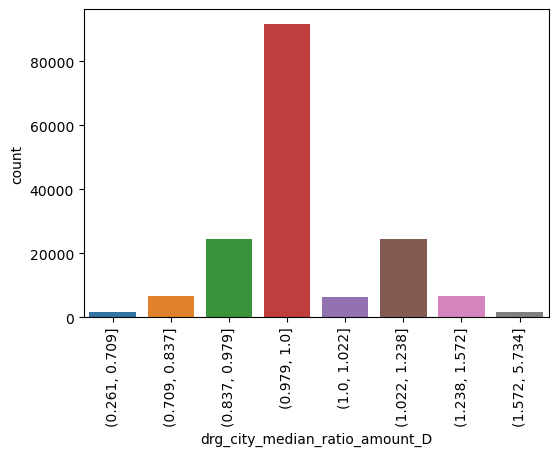

In [35]:
# create bencharmark table
benchmark7 = data.groupby(['Provider_City','DRG'])['Average_Medicare_Payment'].median().reset_index()
benchmark7.columns = ['Provider_City','DRG','Median_Amount_ByCityDRG']
# add the new feature to the dataset 
data7 = pd.merge(data, benchmark7, how='left', on=['Provider_City', 'DRG'])
data7['drg_city_median_ratio_amount'] = np.where(data7['Median_Amount_ByCityDRG']==0,0,data7['Average_Medicare_Payment'] / data7['Median_Amount_ByCityDRG'])
# cut by percentile for plotting
var = 'drg_city_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data7[binned_var] = pd.qcut(data7[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_city_median_ratio_amount_D", data=data7)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' median Medicare payment amounts are around the group's median, compared to the similar hospitals serving same DRG in the same state.
- From the above distribution histogram, we can see that some hospitals' median Medicare payment amounts can be more than 5 times of the group's median, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within a similar range of prices. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing and kickbacks.
- Some hospitals' median medicare payment amounts can be less than 30% of the group's median. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims.
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [36]:
data7[data7['drg_city_median_ratio_amount']>5]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Amount_ByCityDRG,drg_city_median_ratio_amount,drg_city_median_ratio_amount_D
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.0,89.82,6494.005,5.733904,"(1.572, 5.734]"


There is 1 hospital whose median Medicare payment amounts are more than 5 times of the group's median. To be noted, this hospital has been identified as anomaly in feature 1, 3 and 5's (the previous Medicare payment amount ratios) distributions as well. Its Medicare reimbursement rate (90%) is higher than the national average. The mean payment of its peers, serving same ORG in the same city, is within a normal range. This hospital's high average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [37]:
data7[data7['drg_city_median_ratio_amount']<0.3]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Amount_ByCityDRG,drg_city_median_ratio_amount,drg_city_median_ratio_amount_D
109456,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150126,FRANCISCAN ST ANTHONY HEALTH - CROWN POINT,1201 S MAIN ST,CROWN POINT,IN,46307,IN - Gary,13,23478.61,19644.84,83.67,75055.705,0.261737,"(0.261, 0.709]"


There is 1 hospital whose median Medicare payment amounts are less than 30% of the group's average. However, its reimbursement rate (84%) is closed to the national median reimbursement rate. Therefore, the low Medicare payment amounts might be caused by the hospital's small size or the DRG (460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC) might not be the hospital's specialized service. It may not be an anomaly.

####  3.2.4 Feature 8: The ratio to the median medicare reimbursement rate (grouping by DRG & City) <a class="anchor" id="324"></a>

- The defined hospital group's median of medicare reimbursement rate is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group median is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.213, 0.813]'),
 Text(1, 0, '(0.813, 0.924]'),
 Text(2, 0, '(0.924, 0.993]'),
 Text(3, 0, '(0.993, 1.0]'),
 Text(4, 0, '(1.0, 1.006]'),
 Text(5, 0, '(1.006, 1.058]'),
 Text(6, 0, '(1.058, 1.128]'),
 Text(7, 0, '(1.128, 1.87]')]

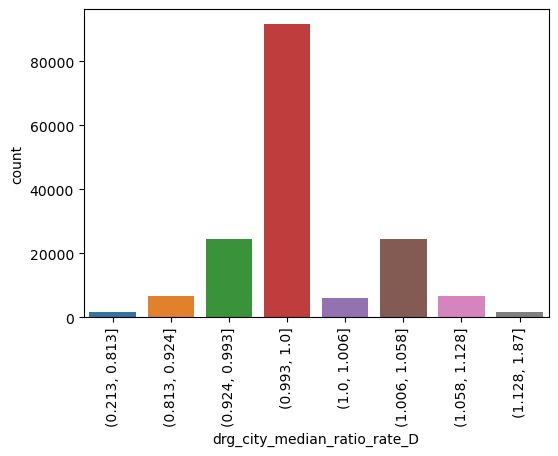

In [38]:
# create bencharmark table
benchmark8 = data.groupby(['Provider_City','DRG'])['Medicare_Reimburse_Rate'].median().reset_index()
benchmark8.columns = ['Provider_City','DRG','Median_Rate_ByCityDRG']
# add the new feature to the dataset 
data8 = pd.merge(data, benchmark8, how='left', on=['Provider_City', 'DRG'])
data8['drg_city_median_ratio_rate'] = np.where(data8['Median_Rate_ByCityDRG']==0,0,data8['Medicare_Reimburse_Rate'] / data8['Median_Rate_ByCityDRG'])
# cut by percentile for plotting
var = 'drg_city_median_ratio_rate'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data8[binned_var] = pd.qcut(data8[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_city_median_ratio_rate_D", data=data8)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' median Medicare reimbursement rates are around the group's median, compared to the similar hospitals serving same DRG in the same city.
- From the above distribution histogram, we can see that some hospitals' median Medicare reimbursement rates are just more than 1.8 times of the group's median, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. We've discussed in EDA that the national median Medicare reimbursement rate is very high (85%), so the just 30% increase could make the reimbursement rate reaching to 100%, which means all of the hospital's bills are reimbursed by Medicare. Same diagnosis should be treated with similar treatments, which are within the same range of reimbursement rate, according to Medicare's insurance policy. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing.
- Some hospitals' median Medicare reimbursement rates can be less than 30% of the group's median. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims.
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [39]:
data8[data8['drg_city_median_ratio_rate'] > 1.7]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Rate_ByCityDRG,drg_city_median_ratio_rate,drg_city_median_ratio_rate_D
20368,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390044,READING HOSPITAL MEDICAL CENTER,SIXTH AVENUE AND SPRUCE ST,READING,PA,19603,PA - Reading,117,9842.23,8687.55,88.27,49.435,1.785577,"(1.128, 1.87]"
47955,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430027,SANFORD USD MEDICAL CENTER,1305 W 18TH ST PO BOX 5039,SIOUX FALLS,SD,57117,SD - Sioux Falls,183,12408.42,11159.24,89.93,50.545,1.779207,"(1.128, 1.87]"
124347,602 - CELLULITIS W MCC,280013,THE NEBRASKA MEDICAL CENTER,987400 NEBRASKA MEDICAL CENTER,OMAHA,NE,68198,NE - Omaha,23,12083.13,11423.56,94.54,50.560,1.869858,"(1.128, 1.87]"


There are 3 hospitals whose median Medicare reimbursement rates are more than 1.7 times of the group's average. All of them are located in different cities, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 88%) compared to to their peers (less than 51%). The average reimbursement rates of their peers, serving same ORG in the same cities, are within a normal range. To be noted, all of them have been identified as anomaly in the other features' distributions as well. This hospital's high average Medicare reimbursement rates can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [40]:
data8[data8['drg_city_median_ratio_rate'] < 0.3]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Rate_ByCityDRG,drg_city_median_ratio_rate,drg_city_median_ratio_rate_D
4568,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,120011,KAISER FOUNDATION HOSPITAL,3288 MOANALUA RD,HONOLULU,HI,96819,HI - Honolulu,12,21032.08,4109.25,19.54,76.990,0.253799,"(0.213, 0.813]"
20388,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,READING,PA,19605,PA - Reading,143,72797.93,7718.09,10.60,49.435,0.214423,"(0.213, 0.813]"
47957,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,SIOUX FALLS,SD,57108,SD - Sioux Falls,121,83484.14,9316.11,11.16,50.545,0.220793,"(0.213, 0.813]"
146340,699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC,450056,SETON MEDICAL CENTER AUSTIN,1201 W 38TH ST,AUSTIN,TX,78705,TX - Austin,31,20136.45,3871.70,19.23,80.065,0.240180,"(0.213, 0.813]"


There are 4 hospitals whose average Medicare reimbursement rates are less than 30% of the group's average. All of them are located in different cities, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 20%). The average reimbursement rates of their peers, serving same ORG in the same city, is within a normal range. To be noted, 3 of them have been identified as anomaly in the other features' distributions as well. These 4 hospitals' low average Medicare reimbursement rates can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

###  3.3 Benchmark: DRG & Hospital Referral Region average/median <a class="anchor" id="33"></a>
Hospitals are grouped by DRG & Hospital Referral Region.

####  3.3.1 Feature 9: The ratio to the average of average medicare payment amount (grouping by DRG & Hospital Referral Region) <a class="anchor" id="331"></a>

- The defined hospital group's average of average medicare payment amount is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.339, 0.7]'),
 Text(1, 0, '(0.7, 0.779]'),
 Text(2, 0, '(0.779, 0.873]'),
 Text(3, 0, '(0.873, 0.977]'),
 Text(4, 0, '(0.977, 1.093]'),
 Text(5, 0, '(1.093, 1.337]'),
 Text(6, 0, '(1.337, 1.613]'),
 Text(7, 0, '(1.613, 4.517]')]

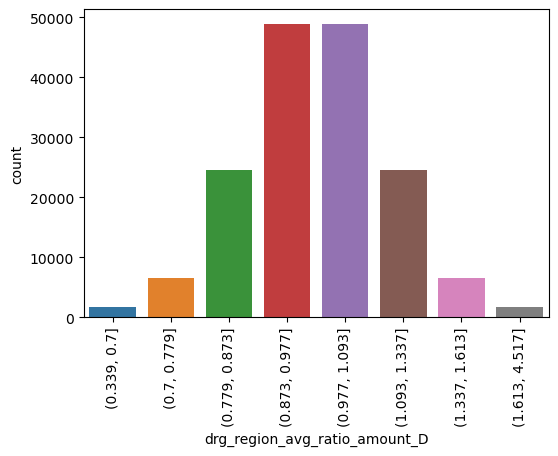

In [41]:
# create bencharmark table
benchmark9 = data.groupby(['Hospital_referral_region_desp','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark9.columns = ['Hospital_referral_region_desp','DRG','Avg_Amount_ByRegionDRG']
# add the new feature to the dataset 
data9 = pd.merge(data, benchmark9, how='left', on=['Hospital_referral_region_desp', 'DRG'])
data9['drg_region_avg_ratio_amount'] = np.where(data9['Avg_Amount_ByRegionDRG']==0,0,data9['Average_Medicare_Payment'] / data9['Avg_Amount_ByRegionDRG'])
# cut by percentile for plotting
var = 'drg_region_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data9[binned_var] = pd.qcut(data9[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_region_avg_ratio_amount_D", data=data9)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' average Medicare payment amounts are around the group's average, compared to the similar hospitals serving same DRG in the same hospital referral region.
- From the above distribution histogram, we can see that some hospitals' average Medicare payment amounts can be more than 4 times of the group's average, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within a similar range of prices. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing and kickbacks. 
- Some hospitals' average Medicare payment amounts can be less than 40% of the group's average. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [42]:
data9[data9['drg_region_avg_ratio_amount']>4]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Amount_ByRegionDRG,drg_region_avg_ratio_amount,drg_region_avg_ratio_amount_D
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.0,89.82,8244.430556,4.516504,"(1.613, 4.517]"


There is 1 hospital1 whose average Medicare payment amounts are more than 4 times of the group's average. It has a high reimbursement rate (more than 89%). The average payments of its peers, serving same ORG in the same hospital referral region, is within a normal range. This hospital's high average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. To be noted, this hospital has been identified as anomaly in other features' distributions as well. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [43]:
data9[data9['drg_region_avg_ratio_amount']<0.35]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Amount_ByRegionDRG,drg_region_avg_ratio_amount,drg_region_avg_ratio_amount_D
109837,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,330286,GOOD SAMARITAN HOSPITAL MEDICAL CENTER,1000 MONTAUK HIGHWAY,WEST ISLIP,NY,11795,NY - East Long Island,12,44431.83,8993.91,20.24,26444.439091,0.340106,"(0.339, 0.7]"
111962,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,120011,KAISER FOUNDATION HOSPITAL,3288 MOANALUA RD,HONOLULU,HI,96819,HI - Honolulu,28,20955.35,5215.00,24.89,15345.876364,0.339831,"(0.339, 0.7]"


There are 2 hospitals whose average Medicare payment amounts are less than 35% of the group's average. All of them are located in different hospital referral regions, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 25%). The average payments of their peers, serving same ORG in the same state, are within a normal range. These 2 hospitals' low average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

####  3.3.2 Feature 10: The ratio to the average medicare reimbursement rate (grouping by DRG & Hospital Referral Region) <a class="anchor" id="332"></a>

- The defined hospital group's average of medicare reimbursement rate is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.0745, 0.755]'),
 Text(1, 0, '(0.755, 0.879]'),
 Text(2, 0, '(0.879, 0.964]'),
 Text(3, 0, '(0.964, 1.006]'),
 Text(4, 0, '(1.006, 1.044]'),
 Text(5, 0, '(1.044, 1.093]'),
 Text(6, 0, '(1.093, 1.153]'),
 Text(7, 0, '(1.153, 1.654]')]

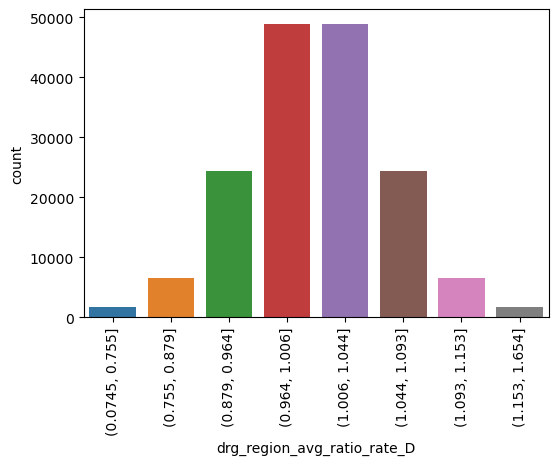

In [44]:
# create bencharmark table
benchmark10 = data.groupby(['Hospital_referral_region_desp','DRG'])['Medicare_Reimburse_Rate'].mean().reset_index()
benchmark10.columns = ['Hospital_referral_region_desp','DRG','Avg_Rate_ByRegionDRG']
# add the new feature to the dataset 
data10 = pd.merge(data, benchmark10, how='left', on=['Hospital_referral_region_desp', 'DRG'])
data10['drg_region_avg_ratio_rate'] = np.where(data10['Avg_Rate_ByRegionDRG']==0,0,data10['Medicare_Reimburse_Rate'] / data10['Avg_Rate_ByRegionDRG'])
# cut by percentile for plotting
var = 'drg_region_avg_ratio_rate'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data10[binned_var] = pd.qcut(data10[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_region_avg_ratio_rate_D", data=data10)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' average Medicare reimbursement rates are around the group's average, compared to the similar hospitals serving same DRG in the same hospital referral region. 
- From the above distribution histogram, we can see that some hospitals' average Medicare reimbursement rates are just more than 1.6 times of the group's average, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. We've discussed in EDA that the national average Medicare reimbursement rate is very high (85%), so the just 30% increase could make the reimbursement rate reaching to 100%, which means all of the hospital's bills are reimbursed by Medicare. Same diagnosis should be treated with similar treatments, which are within the same range of reimbursement rate, according to Medicare's insurance policy. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing. 
- Some hospitals' average Medicare reimbursement rates can be less than 20% of the group's average. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [45]:
data10[data10['drg_region_avg_ratio_rate']>1.6]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Rate_ByRegionDRG,drg_region_avg_ratio_rate,drg_region_avg_ratio_rate_D
38697,203 - BRONCHITIS & ASTHMA W/O CC/MCC,100122,NORTH OKALOOSA MEDICAL CENTER,151 REDSTONE AVE SE,CRESTVIEW,FL,32539,FL - Pensacola,24,3411.0,2568.66,75.31,46.84,1.607814,"(1.153, 1.654]"
49791,251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY...,430027,SANFORD USD MEDICAL CENTER,1305 W 18TH ST PO BOX 5039,SIOUX FALLS,SD,57117,SD - Sioux Falls,44,11301.0,10315.09,91.28,55.20,1.653623,"(1.153, 1.654]"


There are 2 hospitals whose average Medicare reimbursement rates are more than 1.6 times of the group's average. All of them are located in different hospital referral regions, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have higher reimbursement rates (more than 75%) compared to to their peers (less than 55%). The average reimbursement rates of their peers, serving same ORG in the same state, are within a normal range. These 2 hospitals' high average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [46]:
data10[data10['drg_region_avg_ratio_rate']<0.2]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Avg_Rate_ByRegionDRG,drg_region_avg_ratio_rate,drg_region_avg_ratio_rate_D
20388,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,READING,PA,19605,PA - Reading,143,72797.93,7718.09,10.60,66.952500,0.158321,"(0.0745, 0.755]"
38923,203 - BRONCHITIS & ASTHMA W/O CC/MCC,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,RI - Providence,11,41482.09,1790.18,4.32,57.246000,0.075464,"(0.0745, 0.755]"
47957,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,SIOUX FALLS,SD,57108,SD - Sioux Falls,121,83484.14,9316.11,11.16,63.690000,0.175224,"(0.0745, 0.755]"
49145,249 - PERC CARDIOVASC PROC W NON-DRUG-ELUTING ...,500051,OVERLAKE HOSPITAL MEDICAL CENTER,1035-116TH AVE NE,BELLEVUE,WA,98004,WA - Seattle,23,84499.26,8500.60,10.06,74.853333,0.134396,"(0.0745, 0.755]"


There are 4 hospitals whose average Medicare payment amounts are less than 20% of the group's average. All of them are located in different regions, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 12%). The average payments of their peers, serving same ORG in the same state, are within a normal range. These 4 hospitals' low average Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

####  3.3.3 Feature 11: The ratio to the median of average medicare payment amount (grouping by DRG & Hospital Referral Region) <a class="anchor" id="333"></a>

- The defined hospital group's median of average medicare payment amount is used as benchmark for anomaly detection. 
- The ratio of each hospital to the group median is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.331, 0.727]'),
 Text(1, 0, '(0.727, 0.816]'),
 Text(2, 0, '(0.816, 0.915]'),
 Text(3, 0, '(0.915, 1.0]'),
 Text(4, 0, '(1.0, 1.118]'),
 Text(5, 0, '(1.118, 1.43]'),
 Text(6, 0, '(1.43, 1.773]'),
 Text(7, 0, '(1.773, 5.734]')]

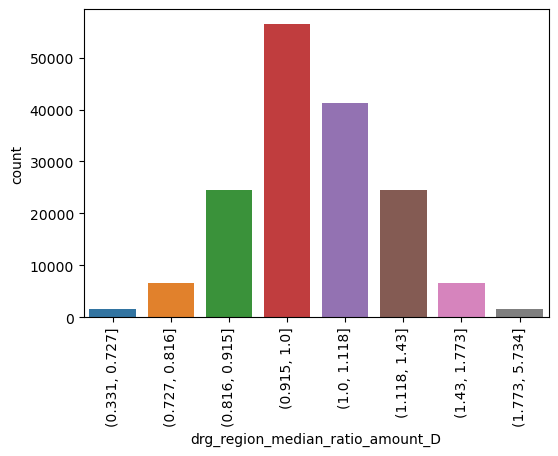

In [47]:
# create bencharmark table
benchmark11 = data.groupby(['Hospital_referral_region_desp','DRG'])['Average_Medicare_Payment'].median().reset_index()
benchmark11.columns = ['Hospital_referral_region_desp','DRG','Median_Amount_ByRegionDRG']
# add the new feature to the dataset 
data11 = pd.merge(data, benchmark11, how='left', on=['Hospital_referral_region_desp', 'DRG'])
data11['drg_region_median_ratio_amount'] = np.where(data11['Median_Amount_ByRegionDRG']==0,0,data11['Average_Medicare_Payment'] / data11['Median_Amount_ByRegionDRG'])
# cut by percentile for plotting
var = 'drg_region_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data11[binned_var] = pd.qcut(data11[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_region_median_ratio_amount_D", data=data11)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' median Medicare payment amounts are around the group's median, compared to the similar hospitals serving same DRG in the same hospital referral region.
- From the above distribution histogram, we can see that some hospitals' median Medicare payment amounts can be more than 5 times of the group's median, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within a similar range of prices. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing and kickbacks. 
- Some hospitals' median Medicare payment amounts can be less than 40% of the group's median. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [48]:
data11[data11['drg_region_median_ratio_amount'] > 5]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Amount_ByRegionDRG,drg_region_median_ratio_amount,drg_region_median_ratio_amount_D
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.00,89.82,6494.005,5.733904,"(1.773, 5.734]"
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,CROWN POINT,IN,46307,IN - Gary,14,131187.35,130466.57,99.45,24653.735,5.291960,"(1.773, 5.734]"
111075,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,390256,MILTON S HERSHEY MEDICAL CENTER,500 UNIVERSITY DRIVE,HERSHEY,PA,17033,PA - Harrisburg,15,100018.33,99114.86,99.10,18136.070,5.465068,"(1.773, 5.734]"


There are 3 hospitals whose median Medicare payment amounts are more than 5 times of the group's median. All of them are located in different regions, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have high reimbursement rates (more than 89%). The reimbursement rates of PINNACLE HOSPITAL and MILTON S HERSHEY MEDICAL CENTERare even higher than 99%. The median payments of their peers, serving same ORG in the same region, are within a normal range. To be noted, these 3 hospitals have been identified as anomalies in other features' distribution as well. These 3 hospitals' high median Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource abuse.

In [49]:
data11[data11['drg_region_median_ratio_amount'] < 0.4]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Amount_ByRegionDRG,drg_region_median_ratio_amount,drg_region_median_ratio_amount_D
109837,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,330286,GOOD SAMARITAN HOSPITAL MEDICAL CENTER,1000 MONTAUK HIGHWAY,WEST ISLIP,NY,11795,NY - East Long Island,12,44431.83,8993.91,20.24,27112.33,0.331728,"(0.331, 0.727]"
111962,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,120011,KAISER FOUNDATION HOSPITAL,3288 MOANALUA RD,HONOLULU,HI,96819,HI - Honolulu,28,20955.35,5215.00,24.89,14085.45,0.370240,"(0.331, 0.727]"


There are 2 hospitals whose median Medicare payment amounts are less than 40% of the group's median. All of them are located in different regions, and providing different DRG. Therefore, they are less likely to relate to each other. All of them have very low reimbursement rates (less than 25%). To be noted, these hospitals have been identified as anomalies in other features' distributions as well. The median payments of their peers, serving same ORG in the same state, are within a normal range. These 2 hospitals' low median Medicare payment amounts can not reasonably be explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

####  3.3.4 Feature 12: The ratio to the median medicare reimbursement rate (grouping by DRG & Hospital Referral Region) <a class="anchor" id="334"></a>

- The defined hospital group's median of medicare reimbursement rate is used as benchmark for anomaly detection. 
- The ratio of each hospital to the median average is calculated as the new feature. 
- To better look at the distribution of the ratios, I cut them into different groups by percentile, and then use a histogram to visualize the distribution.

[Text(0, 0, '(0.0644, 0.729]'),
 Text(1, 0, '(0.729, 0.863]'),
 Text(2, 0, '(0.863, 0.959]'),
 Text(3, 0, '(0.959, 1.0]'),
 Text(4, 0, '(1.0, 1.028]'),
 Text(5, 0, '(1.028, 1.077]'),
 Text(6, 0, '(1.077, 1.138]'),
 Text(7, 0, '(1.138, 2.053]')]

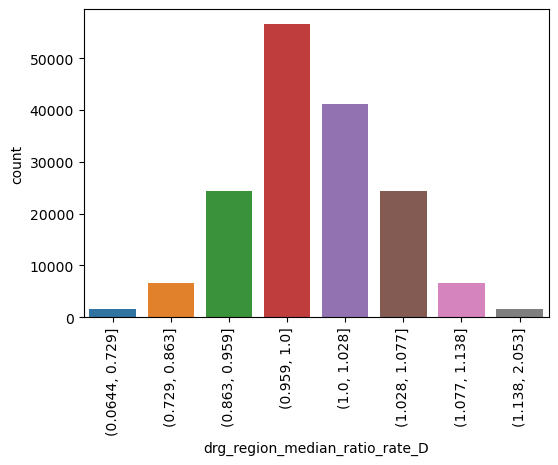

In [50]:
# create bencharmark table
benchmark12 = data.groupby(['Hospital_referral_region_desp','DRG'])['Medicare_Reimburse_Rate'].median().reset_index()
benchmark12.columns = ['Hospital_referral_region_desp','DRG','Median_Rate_ByRegionDRG']
# add the new feature to the dataset 
data12 = pd.merge(data, benchmark12, how='left', on=['Hospital_referral_region_desp', 'DRG'])
data12['drg_region_median_ratio_rate'] = np.where(data12['Median_Rate_ByRegionDRG']==0,0,data12['Medicare_Reimburse_Rate'] / data12['Median_Rate_ByRegionDRG'])
# cut by percentile for plotting
var = 'drg_region_median_ratio_rate'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data12[binned_var] = pd.qcut(data12[var],percentile, duplicates = 'drop')
# Histogram of new feature
plt.figure(figsize=(6,4))
g = sns.countplot(x="drg_region_median_ratio_rate_D", data=data12)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- The distribution histogram shows most of the hospitals' median Medicare reimbursement rates are around the group's median, compared to the similar hospitals serving same DRG in the same hospital refferal region. 
- From the above distribution histogram, we can see that some hospitals' median Medicare reimbursement rates are just more than 2 times of the group's median, and their frequencies are extremely low. Therefore, we should identify these hospitals as anomalies. Same diagnosis should be treated with similar treatments, which are within the same range of reimbursement rate, according to Medicare's insurance policy. The extremely high reimbursement amounts may indicate potential healthcare resources abuse or fraud, including excessive or unnecessary services, upcoding, unbundling, phantom billing. 
- Some hospitals' median Medicare reimbursement rates can be less than 10% of the group's median. It could due to the coverage of other insurance programs. However, it can also indicate some potential disparities in resource utilization. For example, some services provided by those hospitals may be necessary but not covered by Medicare. It can also be indicators of problematic claims. 
- While building the unsupervised machine learning models for better detection, clustering analysis of this feature can be considered to highlight similar (specialization and size) hospitals and identify outlier hospitals for further analysis. Link analysis of this feature can help detect excessive or unnecessary services within and across hospital groups.
- I am going to have an initial investigation on the hospitals identified as anomalies.

In [51]:
data12[data12['drg_region_median_ratio_rate']>2]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Rate_ByRegionDRG,drg_region_median_ratio_rate,drg_region_median_ratio_rate_D
122842,"563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...",10036,ANDALUSIA REGIONAL HOSPITAL,849 SOUTH THREE NOTCH STREET,ANDALUSIA,AL,36420,FL - Pensacola,11,4016.0,3507.27,87.33,42.54,2.052891,"(1.138, 2.053]"


There is 1 hospital whose median Medicare reimbursement rates are more than 2 times of the group's median. This hospital's median reimbursement rate (87%) is closed to the national average, while the median (42.54%) of its peers, serving same ORG in the same region, is much lower than the national average. It could be caused by the low standard reimbursement rate of this DRG catogory, or the hospital's resourses abuse. Although we can not decided whether it's an anomaly, CMS should still further invesitage with their transactional claims, including hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when conducting evaluation.

In [52]:
data12[data12['drg_region_median_ratio_rate']<0.1]

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,Median_Rate_ByRegionDRG,drg_region_median_ratio_rate,drg_region_median_ratio_rate_D
38923,203 - BRONCHITIS & ASTHMA W/O CC/MCC,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,RI - Providence,11,41482.09,1790.18,4.32,66.05,0.065405,"(0.0644, 0.729]"


There is 1 hospital whose average Medicare reimbursement rate is less than 10% of the group's average. Its reimbursement rate is very low, even less than 5%. The median reimbursement rates of their peers, serving same ORG in the same state, are within a normal range. This hospital's low median Medicare reimbursement rate can not reasonably explained, therefore, indeed abnormal. CMS can further invesitage with their transactional claims, including hospital's size and specialization, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier, etc. It's important to consider these contextual factors when evaluating potential resource underutilization or inadequate reimbursement.

## Section 4 Conclusion <a class="anchor" id="4"></a>

To conclude the above analyses of EDA and FE:
- The national distributions can demostrate the normal range of average Medicare payment amount and average Medicare reimbursement rate for general comparison. 
- Features are created based on different levels of grouping. We can capture the reimbursement pattern of defined hospital group. 
- The outliers and anomalies detected from these hospital group should be investigated with more contextual information (eg. transactional claims, hospital's specialization and size, patient's demographics, type and frequency of drug usage, drug or other healthcare service's supplier). 
- There are some hospitals identified as anomalies in multiple features' distributions. They should be deeply investigated.
- We can cross check multiple features for a certain hospital, to evaluate whether it can be reasonably exlpained.
- Features created above can be used in unsupervised models like cluster analysis, link analysis and network analysis.

###  4.1 Combine New Features to Dataset <a class="anchor" id="41"></a>

In [53]:
# Combine new features to the origininal dataset
data['drg_state_avg_ratio_amount'] = data1['drg_state_avg_ratio_amount']
data['drg_state_avg_ratio_rate'] = data2['drg_state_avg_ratio_rate']
data['drg_state_median_ratio_amount'] = data3['drg_state_median_ratio_amount']
data['drg_state_median_ratio_rate'] = data4['drg_state_median_ratio_rate']
data['drg_city_avg_ratio_amount'] = data5['drg_city_avg_ratio_amount']
data['drg_city_avg_ratio_rate'] = data6['drg_city_avg_ratio_rate']
data['drg_city_median_ratio_amount'] = data7['drg_city_median_ratio_amount']
data['drg_city_median_ratio_rate'] = data8['drg_city_median_ratio_rate']
data['drg_region_avg_ratio_amount'] = data9['drg_region_avg_ratio_amount']
data['drg_region_avg_ratio_rate'] = data10['drg_region_avg_ratio_rate']
data['drg_region_median_ratio_amount'] = data11['drg_region_median_ratio_amount']
data['drg_region_median_ratio_rate'] = data12['drg_region_median_ratio_rate']
data.to_csv('inpatientCharges_fe.csv', index=False)

In [54]:
# Check the data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   DRG                             163065 non-null  category
 1   Provider_Id                     163065 non-null  category
 2   Provider_Name                   163065 non-null  object  
 3   Provider_StreetAddress          163065 non-null  object  
 4   Provider_City                   163065 non-null  category
 5   Provider_State                  163065 non-null  category
 6   Provider_Zipcode                163065 non-null  int64   
 7   Hospital_referral_region_desp   163065 non-null  object  
 8   Total_Discharges                163065 non-null  int64   
 9   Average_Total_Payments          163065 non-null  float64 
 10  Average_Medicare_Payment        163065 non-null  float64 
 11  Medicare_Reimburse_Rate         163065 non-null  float64 
 12  dr

In [55]:
# Get the Simple Summary Statistics 
data.describe()

,Provider_Zipcode,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Reimburse_Rate,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_city_avg_ratio_amount,drg_city_avg_ratio_rate,drg_city_median_ratio_amount,drg_city_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate
count,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000
mean,47938.121908,42.776304,9707.473804,8494.490964,84.654478,0.846842,1.000000,1.055484,0.985465,1.000000,1.000000,1.012910,0.996948,1.000000,1.000000,1.038494,0.989270
std,27854.323080,51.104042,7664.642598,7309.467261,8.791137,0.193528,0.076404,0.234139,0.075892,0.119402,0.047966,0.133973,0.048960,0.175920,0.070109,0.196388,0.070707
min,1040.000000,11.000000,2673.000000,1148.900000,4.320000,0.266055,0.057806,0.367836,0.056353,0.261737,0.214423,0.261737,0.214423,0.339831,0.075464,0.331728,0.065405
25%,27261.000000,17.000000,5234.500000,4192.350000,79.660000,0.725021,0.973331,0.916191,0.962159,0.979755,1.000000,1.000000,1.000000,0.893506,0.975883,0.935187,0.971253
50%,44309.000000,27.000000,7214.100000,6158.460000,86.020000,0.808729,1.012884,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976954,1.006240,1.000000,1.000000
75%,72901.000000,49.000000,11286.400000,10056.880000,91.350000,0.917944,1.041884,1.121178,1.024671,1.000000,1.004751,1.000000,1.000000,1.063344,1.035999,1.082952,1.020547
max,99835.000000,3383.000000,156158.180000,154620.810000,100.000000,4.446219,1.381825,6.030981,1.431109,3.846861,1.785577,5.733904,1.869858,4.516504,1.653623,5.733904,2.052891
